In [9]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras



n_classes = 1
x_idx = 8 # position where the 2D slice has been interpreted

data3D  = np.random.normal(size=(100,16,16,16,1)).astype(np.float32) # shape is [x,y,z,channels]
label2D = np.random.normal(size=(100,16,16,n_classes)).astype(np.float32) # shape is [y,z,n_classes] at x=x_idx


# Initialize 3D labels with zeros
label3D = np.zeros((100,16,16,16,n_classes),dtype=np.float32) # shape is [x,y,z,n_classes]

# Write 2D labels at correct position
label3D[:,x_idx,...] = label2D

# Create 3D binary mask. 1 where we have valid labels, 0 elsewhere
mask = np.zeros((100,16,16,16),dtype=np.float32) # shape is [x,y,z]
mask[x_idx,:,:] = 1.


# Define model
size = 16

def down_block(x, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool3D((2, 2, 2), (2, 2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling3D((2, 2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv3D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c



def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((size, size, size, 1))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv3D(1, (1, 1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model

model = UNet()

logits = model(data3D)
loss = tf.compat.v1.losses.softmax_cross_entropy(label3D, logits, weights=mask)


model.compile(optimizer="adam", loss=loss, metrics=["acc"])

model.fit(data3D, label3D, epochs=3)


Epoch 1/3


ValueError: ignored

# How to train a 3-D CNN with 2-D labels

This tutorial describes how to train a 3-D convolutional neural network with 3-D seismic reflection data, but only 2-D labels using a masked loss function. Using 2-D labels is really useful, because 3-D labelling would be really time-consuming (you would need to label a large number of closely-spaced 2-D lines). So this is a nice trick! Thanks to Valentin Tschannen and co-authors for showing us how to do this! Check out their excellent paper: [https://doi.org/10.1190/geo2019-0569.1](https://doi.org/10.1190/geo2019-0569.1)


## Setup ##

1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-5/tutorial-5.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


## Pre-processing ##
Now that everything is set up, we load a couple of python packages, we will use:


In [1]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt

from PIL import Image

import tensorflow as tf
from tensorflow import keras

and clone our git repository:

In [2]:
!git clone https://github.com/thilowrona/seismic_deep_learning

Cloning into 'seismic_deep_learning'...
remote: Enumerating objects: 533, done.
remote: Total 533 (delta 0), reused 0 (delta 0), pack-reused 533
Receiving objects: 100% (533/533), 28.52 MiB | 8.37 MiB/s, done.
Resolving deltas: 100% (263/263), done.


Now we want to load a 3-D seismic volume onto our virtual machine. There are a couple public datasets available, for example at [https://terranubis.com/datalist/free](https://terranubis.com/datalist/free).

Let's say we want to use the F3 dataset from the Netherlands: [https://terranubis.com/datainfo/F3-Demo-2020](https://terranubis.com/datainfo/F3-Demo-2020). You can download this dataset onto our virtual machine like this (this taks a bit):


In [3]:
!pip install googledrivedownloader

from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

Now we install and load [segpy](https://github.com/sixty-north/segpy), a package to load seismic data (.sgy or .segy files):

In [4]:
!pip install segpy

import segpy
from segpy.reader import create_reader

     |████████████████████████████████| 71kB 2.2MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 112kB 8.6MB/s 


Next you can load (and scale) the F3 dataset:

In [5]:
filename = "./Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

data = (data-np.min(data))/(np.max(data)-np.min(data))

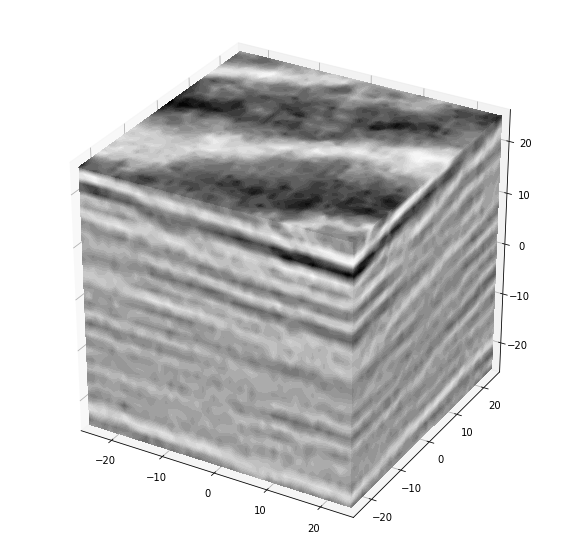

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def plot_cube(data, size=5, levels=30, cmap='Greys'):

  
    
    X = np.linspace(-size, size, data.shape[0])
    Y = np.linspace(-size, size, data.shape[2])
    X, Y = np.meshgrid(X, Y)
    
    

    X_normal = data[0,:,:]
    Y_normal = np.transpose(data[:,:,0])
    Z_normal = np.transpose(data[:,0,:])
    
    
    plt.close('all')
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    
    
    cset = [[],[],[]]
    
    # this is the example that worked for you:
    cset[0] = ax.contourf(X, Y, Z_normal[:,::-1], zdir='z', offset=size, levels=np.linspace(np.min(Z_normal),np.max(Z_normal),levels),cmap=cmap)
    
    # now, for the x-constant face, assign the contour to the x-plot-variable:
    cset[1] = ax.contourf(X_normal[::-1,:], X, Y, zdir='x', offset=size, levels=np.linspace(np.min(X_normal),np.max(X_normal),levels),cmap=cmap)
    
    # likewise, for the y-constant face, assign the contour to the y-plot-variable:
    cset[2] = ax.contourf(X, Y_normal[::-1,::-1], Y, zdir='y', offset=-size, levels=np.linspace(np.min(Y_normal),np.max(Y_normal),levels),cmap=cmap)
    
    # setting 3D-axis-limits:    
    ax.set_xlim3d(-size,size)
    ax.set_ylim3d(-size,size)
    ax.set_zlim3d(-size,size)
    
    plt.show()



plot_cube(data[200:250,200:250,200:250], size=25)


Again we want to map all the faults in the data. To do this, we load our masks:

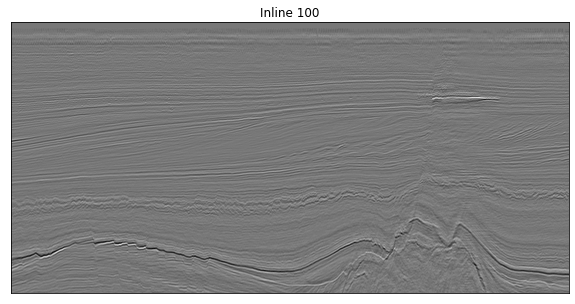

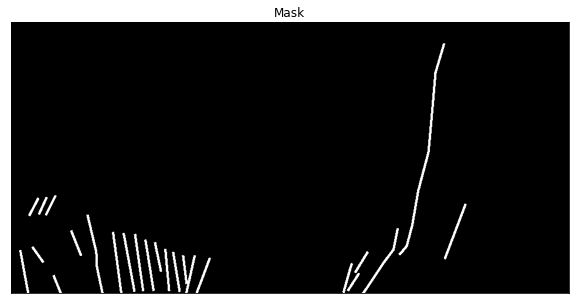

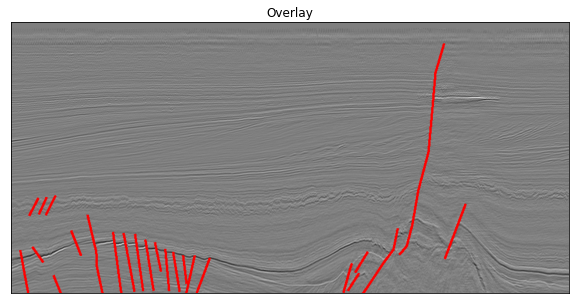

In [7]:
def load_mask(filename):
    mask = Image.open(filename)
    mask.load()
    mask = np.asarray(mask)[:,:,3]
    mask = np.where(mask > 0.5, 1, 0)
    return mask

mask = load_mask('seismic_deep_learning/tutorial-4/mask_inline_100.png')


def plot(data, title, cmap):
    plt.figure(figsize=(10,10))
    plt.imshow(data, interpolation='spline16', cmap=cmap, aspect=1)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()


def plot_overlay(image, mask, title=None):
    (tmax, xmax) = np.shape(image)

    mask_rgb = np.zeros((tmax,xmax,4), 'uint8')
    mask_rgb[:,:,0] = 255
    mask_rgb[:,:,1] = 255 - 255*mask
    mask_rgb[:,:,2] = 255 - 255*mask
    mask_rgb[:,:,3] = 255*mask    
    
    img = Image.fromarray(mask_rgb, mode='RGBA')
    
    image_rgb = np.zeros((tmax,xmax,4), 'uint8')    
    image_rgb[:,:,0] = 255*image
    image_rgb[:,:,1] = 255*image
    image_rgb[:,:,2] = 255*image
    image_rgb[:,:,3] = 255
    
    background = Image.fromarray(image_rgb, mode='RGBA')    
    background.paste(img, (0, 0), img)

    plt.figure(figsize=(10,10))    
    plt.imshow(background)
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    

plot(data[100,:,:], 'Inline 100', plt.cm.gray)
plot(mask, 'Mask', plt.cm.gray)
plot_overlay(data[100,:,:], mask, 'Overlay')

Now we can define a data generator, which extract examples from multiple sections:

In [8]:
def cubify(data, mask, size, number, threshold):
    (z_max, x_max, y_max) = data.shape    
    X = np.zeros((number, size, size, size, 1))
    Y = np.zeros((number, size, size, size, 1))        
    n = 0
    while n < number: 
        x = random.randint(size//2, x_max-size//2)
        y = random.randint(size//2, y_max-size//2)        
        z = random.randint(size//2, z_max-size//2)
        if np.count_nonzero(mask[z-size//2:z+size//2, x-size//2:x+size//2]) > threshold:
            X[n,:,:,:,0]  = data[z-size//2:t+size//2, x-size//2:x+size//2, y-size//2:y+size//2]
            Y[n,:,:,:,0]  = mask[z-size//2:t+size//2, x-size//2:x+size//2]
            n = n + 1
    return X, Y


  

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,
                 datasets,
                 masks,
                 n_exp,
                 wsize,
                 threshold,
                 xmax, 
                 tmax, 
                 scale_image=1, 
                 scale_mask=1, 
                 batch_size=32, 
                 dim=(128,128,1), 
                 shuffle=True):
        
        'Initialization'
        self.datasets = datasets
        self.masks = masks
        self.n_exp = n_exp
        self.wsize = wsize
        self.threshold = threshold
        self.xmax = xmax
        self.tmax = tmax
        self.scale_image = scale_image
        self.scale_mask = scale_mask
        self.batch_size = batch_size
        self.dim = dim        
        self.shuffle = shuffle

        self.n = 0
        self.max = self.__len__()
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_exp / self.batch_size))

    def __getitem__(self, index):
        # Generate data
        X, Y = self.__data_generation()

        return X, Y


    def __data_generation(self):
        'Generates data containing batch_size samples'
        
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        Y = np.empty((self.batch_size, *self.dim))
        
        # Generate data
        n = 0
        for data, mask in zip(self.datasets, self.masks):            
            self.per = self.batch_size//len(self.datasets)            
            X[self.per*n:self.per*(n+1),:,:,:], Y[self.per*n:self.per*(n+1),:,:,:] = cubify(data, mask, self.wsize, self.per, self.threshold)            
            n = n + 1
                        
        return X, Y




    def __next__(self):
      if self.n >= self.max:
        self.n = 0
      result = self.__getitem__(self.n)
      self.n += 1
      return result

Now we create a data generator for training and for validation with 100 000 examples of our data:

In [9]:
def to_lists(files):
    datasets = []
    masks    = []
    for file in files:
        datasets.append(data[file,:,:])
        masks.append(load_mask("seismic_deep_learning/tutorial-4/mask_inline_" + str(file) + ".png"))
    return datasets, masks



# Parameters
size       = 64
threshold  = 0
num_train  = 8000
num_val    = 2000
(tmax, xmax) = (4001, 8605)


batch_size = 32
epochs = 100



inlines_train = [100, 200, 400, 500]                  
inlines_val   = [300]




datasets_train, masks_train = to_lists(inlines_train)

datasets_val, masks_val = to_lists(inlines_val)




datagen_train = DataGenerator(datasets_train,
                              masks_train,
                              num_train,
                              size,
                              threshold,
                              xmax, 
                              tmax, 
                              scale_image=1, 
                              scale_mask=1, 
                              batch_size=batch_size, 
                              dim=(size,size,1), 
                              shuffle=True)
  

datagen_val = DataGenerator(datasets_val,
                            masks_val,
                            num_val,
                            size,
                            threshold,
                            xmax, 
                            tmax, 
                            scale_image=1, 
                            scale_mask=1, 
                            batch_size=batch_size, 
                            dim=(size,size,1), 
                            shuffle=True)

Before training, it's always a good idea to look at the training data, so let's do that:

In [10]:
X_train_batch, Y_train_batch = next(datagen_train)


fig, axs = plt.subplots(2, 10, figsize=(15,3))

k = 0
for m in range(10):
  axs[0,m].imshow(X_train_batch[k,:,:,0], interpolation='spline16', cmap=plt.cm.gray, aspect=1)
  axs[0,m].set_xticks([])
  axs[0,m].set_yticks([])
  k += 1

k = 0
for m in range(10):
  axs[1,m].imshow(Y_train_batch[k,:,:,0], interpolation='spline16', aspect=1)
  axs[1,m].set_xticks([])
  axs[1,m].set_yticks([])
  k += 1


ValueError: ignored

What do you notice?

* Is it an easy task?
* Could you predict the masks?
* Can we learn more from some examples?

## Training ##
To train our model, we need to define its architecture. 



In [ ]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = tf.keras.layers.UpSampling2D((2, 2))(x)
    concat = tf.keras.layers.Concatenate()([us, skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

  


def UNet():
  f = [16, 32, 64, 128, 256]
  inputs = tf.keras.layers.Input((size, size, 1))
  
  p0 = inputs
  c1, p1 = down_block(p0, f[0]) #128 -> 64
  c2, p2 = down_block(p1, f[1]) #64 -> 32
  c3, p3 = down_block(p2, f[2]) #32 -> 16
  c4, p4 = down_block(p3, f[3]) #16->8
  
  bn = bottleneck(p4, f[4])
  
  u1 = up_block(bn, c4, f[3]) #8 -> 16
  u2 = up_block(u1, c3, f[2]) #16 -> 32
  u3 = up_block(u2, c2, f[1]) #32 -> 64
  u4 = up_block(u3, c1, f[0]) #64 -> 128
  
  outputs = tf.keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
  model = tf.keras.models.Model(inputs, outputs)
  return model




model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])

Now you can train your convolutional neural net using the data generator:

In [ ]:
history =  model.fit(datagen_train,
                     steps_per_epoch  = len(datagen_train),
                     validation_data  = datagen_val,
                     validation_steps = len(datagen_val),
                     epochs=5)

To visualize our training, you can plot learning curves:

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Application##
Now we can apply our model to the entire image to see how well it has learned to recognize salt structures in our seismic image:

In [ ]:
def tile(data, wsize, dt, dx):
    
    (t_max, x_max) = data.shape    
    
    n_patch = (t_max//dt+1)*(x_max//dx+1)
    data_patch = np.zeros((n_patch,wsize,wsize,1)) 

    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):    
            if t_max - t < wsize and x_max - x < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x_max-wsize:x_max]
            elif x_max - x < wsize:
                data_patch[n,:,:,0] = data[t:t+wsize, x_max-wsize:x_max]
            elif t_max - t < wsize:
                data_patch[n,:,:,0] = data[t_max-wsize:t_max, x:x+wsize]
            else:
                data_patch[n,:,:,0] = data[t:t+wsize,x:x+wsize]  
            n = n + 1
    
    return data_patch 




def merge(data_patch, t_max, x_max, wsize, dt, dx):

    data_new = np.zeros((t_max, x_max,1))
    count = np.zeros((t_max, x_max, 1))
    
    n = 0
    for t in range(0, t_max, dt):
        for x in range(0, x_max, dx):
            if t_max - t < wsize and x_max - x < wsize:
                data_new[t_max-wsize:t_max, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x_max-wsize:x_max,0] += 1
            elif x_max - x < wsize:
                data_new[t:t+wsize, x_max-wsize:x_max,0] += data_patch[n,:,:,0]
                count[t:t+wsize, x_max-wsize:x_max,0] += 1 
            elif t_max - t < wsize:
                data_new[t_max-wsize:t_max, x:x+wsize,0] += data_patch[n,:,:,0]
                count[t_max-wsize:t_max, x:x+wsize,0] += 1
            else:
                data_new[t:t+wsize,x:x+wsize,0] += data_patch[n,:,:,0]
                count[t:t+wsize,x:x+wsize,0] += 1 
            n = n + 1

    return data_new/count


dt = 64
dx = 64

(_, t_max, x_max) = data.shape

data_tiles   = tile(data[300,:,:], size, dt, dx)
result_tiles = model.predict_on_batch(data_tiles)
result       = merge(result_tiles, t_max, x_max, size, dt, dx)

plot_overlay(data[300,:,:], result[:,:,0], 'Inline 300 + prediction')
mask = load_mask('seismic_deep_learning/tutorial-4/mask_inline_300.png')
plot_overlay(data[300,:,:], mask, 'Inline 300 + mask')
plt.show()

Not too bad for a first try! The model is able to find some of the clearer faults (bottom left) in a seismic image it has not seen before. That's promising! Maybe we can even map these faults in a horizontal slice through the volume:







In [ ]:
depth = 420
time_slice = data[:,depth,:]

plot(time_slice, 'Time slice', plt.cm.gray)

Now let's predict! Again it will take a moment, since we have to process quite a bit of the volume

In [ ]:
(xmax, ymax) = time_slice.shape
nexp=(xmax-2*size)*(ymax-2*size)

coord  = np.zeros((batch_size,2),int)
patch = np.zeros((batch_size,size,size,1))
prediction = np.zeros_like(time_slice)

batch_size = 1000

m=0
n_batch = 0
for x in range(size,xmax-size):
        for y in range(size,ymax-size):
            patch[m,:,:,0] = data[x, depth-size//2:depth+size//2,y-size//2:y+size//2,]
            coord[m,:] = [x, y]                  
            m+=1        
            
            if m == batch_size:
                prediction[coord[:,0], coord[:,1]] = model.predict_on_batch(patch)[:,size//2,size//2,0]
                m=0
                
                print(str(n_batch+1) + ' of ' + str(round(nexp/batch_size)))
                n_batch += 1

In [ ]:
plot_overlay(time_slice, result, 'Time slice with fault prediction')

Awesome! The red lines are fault traces, so our model is able to map at least some these faults in 3-D.

Now that the basic workflow is running, we can think about improving our model... What would you do? Use a more complex model, more training examples or something else? Just try it out and compare your results

In the next tutorial ([tutorial-5](https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-5/tutorial_5.ipynb)), we will go from two to three dimensions using the same dataset to train a 3-D convolutional neural network with labels in 2-D. Check it out!